## Predicting Good Amazon Reviews

For this demo, we will be using the [Amazon Fine Food Reviews Data](https://www.kaggle.com/snap/amazon-fine-food-reviews).  The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.

This script is based off of the [Craigslist Word2Vec Demo](https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb).

Our Machine Learning Workflow is: 

1. Import data into H2O
2. Exploratory Analysis
3. Tokenize Text
4. Train Word2Vec Model
5. Analyze Word Embeddings
6. Train Positive Review Model with Original Data
7. Train Positive Review Model with Word Embeddings
8. Run AutoML
9. View AutoML in Flow
10. Shutdown H2O cluster

# Step 1 (of 10).  Import data into H2O

We will begin by importing our review data into our H2O cluster.

In [1]:
import h2o

In [2]:
h2o.init(max_mem_size="4G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_91"; Java(TM) SE Runtime Environment (build 1.8.0_91-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.91-b14, mixed mode)
  Starting server from /Users/megankurka/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpm_ajkj3i
  JVM stdout: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpm_ajkj3i/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpm_ajkj3i/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.2
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_megankurka_lgncdk
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
# Load data into H2O

# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/nlp/amazon_reviews/AmazonReviews.csv
#reviews = h2o.import_file("../../data/topics/nlp/amazon_reviews/AmazonReviews.csv")
reviews = h2o.import_file("https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/nlp/amazon_reviews/AmazonReviews.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


# Step 2 (of 10).  Exploratory Analysis

We will start our analysis by exploring the dataset and creating our target column.  In this case, we would like to predict whether or not a reviewer liked the product.

In [4]:
print(reviews.dim)

[100000, 10]


In [5]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler """"When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan """"Officefankt""""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena """"doctorsirena""""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says """"Brown Rice Vermicelli"""", making the consumer think """"this is made with brown rice, so it should be a healthy choice"""". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are """"easy-to-cook"""" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much directi

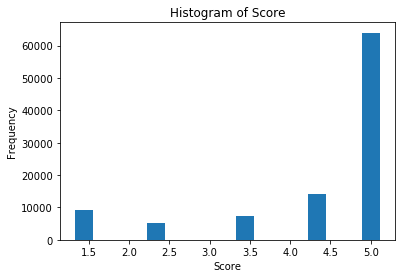

In [6]:
%matplotlib inline
reviews["Score"].hist()

In [7]:
summary_freq = reviews["Summary"].table()
summary_freq = summary_freq.sort("Count", ascending = [False])
summary_freq.head()

Summary,Count
Delicious,426
Delicious!,417
Yummy!,284
Yummy,222
Great product,204
Yum!,193
Excellent,183
Great Product,155
Love it!,154
Great,138


In [8]:
#' Add Target Column: "PositiveReview"
reviews["PositiveReview"] = (reviews["Score"] >= 4).ifelse("1", "0")

In [9]:
reviews["PositiveReview"].table()

PositiveReview,Count
0,21791
1,78209


# Step 3 (of 10).  Tokenize Words


We will tokenize the words in the review column. We will do this by creating a function called `tokenize`.  This will split the reviews into words and remove any stop words, small words, or words with numbers in them.

In [10]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package
import pandas as pd

# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/nlp/amazon_reviews/stopwords.csv
#STOP_WORDS = pd.read_csv("../../data/topics/nlp/amazon_reviews/stopwords.csv", header=0)
STOP_WORDS = pd.read_csv("https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/nlp/amazon_reviews/stopwords.csv", header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

STOP_WORDS

['all',
 'just',
 'being',
 'over',
 'both',
 'through',
 'yourselves',
 'its',
 'before',
 'o',
 'hadn',
 'herself',
 'll',
 'had',
 'should',
 'to',
 'only',
 'won',
 'under',
 'ours',
 'has',
 'do',
 'them',
 'his',
 'very',
 'they',
 'not',
 'during',
 'now',
 'him',
 'nor',
 'd',
 'did',
 'didn',
 'this',
 'she',
 'each',
 'further',
 'where',
 'few',
 'because',
 'doing',
 'some',
 'hasn',
 'are',
 'our',
 'ourselves',
 'out',
 'what',
 'for',
 'while',
 're',
 'does',
 'above',
 'between',
 'mustn',
 't',
 'be',
 'we',
 'who',
 'were',
 'here',
 'shouldn',
 'hers',
 'by',
 'on',
 'about',
 'couldn',
 'of',
 'against',
 's',
 'isn',
 'or',
 'own',
 'into',
 'yourself',
 'down',
 'mightn',
 'wasn',
 'your',
 'from',
 'her',
 'their',
 'aren',
 'there',
 'been',
 'whom',
 'too',
 'wouldn',
 'themselves',
 'weren',
 'was',
 'until',
 'more',
 'himself',
 'that',
 'but',
 'don',
 'with',
 'than',
 'those',
 'he',
 'me',
 'myself',
 'ma',
 'these',
 'up',
 'will',
 'below',
 'ain',
 '

In [11]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [12]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [13]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


# Step 4 (of 10).  Train Word2Vec Model

Now that we've tokenized our words, we can train a word2vec model. We will start by creating word embeddings of length 2.  We will use these to understand the word embedding since they can be easily visualized. 

In [14]:
# Train Word2Vec Model for vec size = 2
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_len2_model = H2OWord2vecEstimator(vec_size = 2, model_id = "w2v_len2.hex")
w2v_len2_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


# Step 5 (of 10).  Analyze Word Embeddings

We have created word embeddings for each word in our corpus, now we want to understand what they mean and how to interpret them.  The word embeddings for the first few words are shown below.

In [15]:
sample_embeddings = words.head()
sample_embeddings.col_names = ["Word"]
sample_embeddings = sample_embeddings.cbind(w2v_len2_model.transform(sample_embeddings, aggregate_method="None"))

sample_embeddings

Word,C1,C2
made,0.53834,-0.338847
china,0.134573,-0.810373
buy,0.278648,-0.730829
pet,-0.322129,-1.27302
food,0.0972247,-0.94408
china,0.134573,-0.810373
dogswell,-0.162063,-1.19581
using,0.506245,-0.40677
propylene,0.906857,0.567227
glycol,0.791394,0.5135


We will plot the word embeddings to see which words are related to one another.

In [16]:
unique_words = words.asfactor().table()
unique_words.col_names = ["Word", "Count"]

word_embeddings = w2v_len2_model.transform(unique_words["Word"].ascharacter(), aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~word_embeddings["C1"].isna()]
word_embeddings.head()

Word,Count,C1,C2
aa,26,0.875071,0.0475979
aaa,9,0.448416,-0.469924
aaaaa,5,0.274079,-0.586905
aaah,6,0.83122,-0.185603
aacute,12,0.392722,0.197443
aafco,8,0.2431,-0.59297
aah,5,0.754727,-0.184267
ab,11,0.81234,0.210216
aback,16,0.586913,-0.303008
abandon,11,0.650477,-0.35015


In [17]:
# Filter Word Embeddings to selected words

selected_words = ["coffee", "espresso", "starbucks", "sweet", "salty", "savory", "email", "support", "answered", 
                  "unhappy", "waited", "returned", "tasty", "yummy", "moldy", "expired", "salmonella", "best", 
                  "amazing", "abdominal", "folic", "zinc"]

filtered_embeddings = word_embeddings[word_embeddings["Word"].isin(selected_words)]
plot_data = filtered_embeddings.as_data_frame(use_pandas = True)

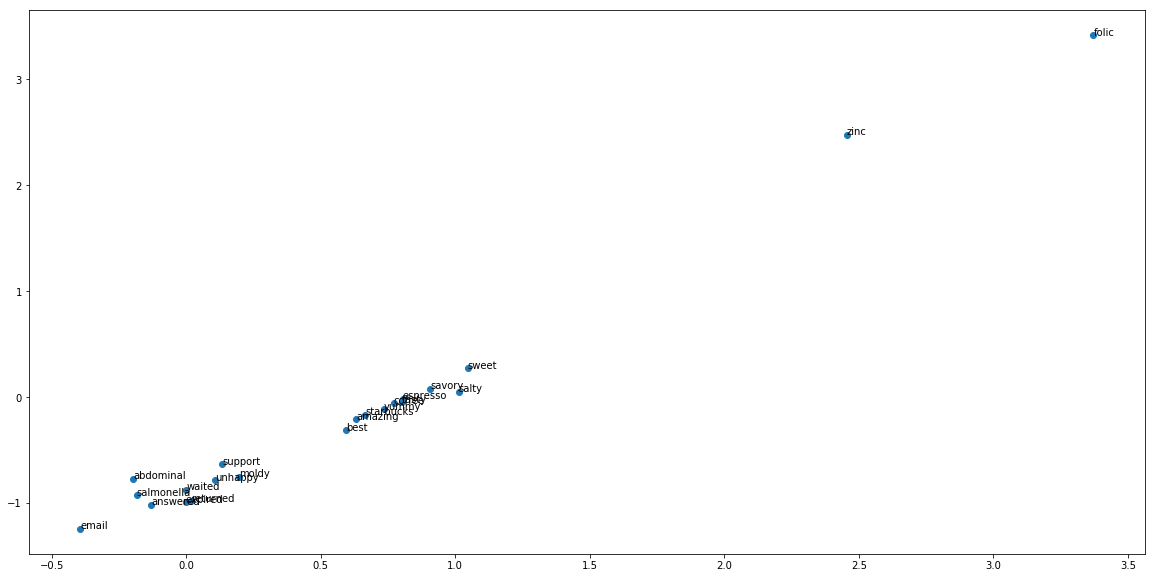

In [18]:
# Plot Word Embeddings
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(plot_data["C1"], plot_data["C2"])

for i, txt in enumerate(plot_data["Word"]):
    ax.annotate(txt, (plot_data["C1"].iloc[i], plot_data["C2"].iloc[i]))

We will train a more complex word2vec model with length 100 - this will be able to catch further nuances in the text.

In [19]:
# Train Word2Vec Model for vec size = 100
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


One way to interpret the word embeddings is to use them to find synonyms. The `find_synonyms` function finds the words that have the smallest cosine distance in word embeddings.  We assume that if the word embeddings are similar, the two words are synonyms.

In [20]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.8106526136398315),
             ('coffees', 0.7752676010131836),
             ('brew', 0.7635484933853149),
             ('espresso', 0.7487479448318481),
             ('expresso', 0.7487366199493408)])

In [21]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('moldy', 0.694185733795166),
             ('rancid', 0.6910488605499268),
             ('inedible', 0.6386507749557495),
             ('staleness', 0.6223535537719727),
             ('unedible', 0.6204297542572021)])

We will cluster the word embeddings to identify segments of similar words. 

In [22]:
word_embeddings = w2v_model.transform(unique_words["Word"].ascharacter(), aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~word_embeddings["C1"].isna()]

In [23]:
from h2o.estimators import H2OKMeansEstimator

kmeans = H2OKMeansEstimator(model_id = "word_segments.hex",
                            estimate_k = True, k = 100, # Max number of clusters
                            seed = 1234)

x = list(set(word_embeddings.col_names) - set(["Word", "Count"]))
kmeans.train(x = x, training_frame = word_embeddings)

kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [24]:
# Clusters
kmeans.centroid_stats()

Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,11684.0,1129712.2806108
,2.0,7395.0,722835.5624282


In [25]:
word_clusters = word_embeddings.cbind(kmeans.predict(word_embeddings))
word_clusters[["Word", "predict"]].head()

kmeans prediction progress: |█████████████████████████████████████████████| 100%


Word,predict
aa,0
aaa,0
aaaaa,0
aaah,0
aacute,0
aafco,1
aah,0
ab,0
aback,0
abandon,0


In [26]:
selected_clusters = word_clusters[word_clusters["Word"].isin(selected_words)]

In [27]:
print("Cluster 0")
print(selected_clusters[selected_clusters["predict"] == 0, "Word"])

Cluster 0


Word
amazing
best
coffee
email
espresso
expired
moldy
returned
salty
savory


In [28]:
print("Cluster 1")
print(selected_clusters[selected_clusters["predict"] == 1, "Word"])

Cluster 1


Word
abdominal
answered
folic
salmonella
support
zinc


# Step 6 (of 10).  Train Model with Original Data

Now that we have analyzed our word embeddings, we will turn to our supervised learning task to predict whether someone liked the review.  We will first train a model on our original data - not our word embeddings to see what our accuracy is. We will use this model as a baseline model.

In [29]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [30]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [31]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )
gbm_baseline.train(x = predictors, y = response, 
                   training_frame = train, validation_frame = test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on Validation Data: 0.616


We can see that there is a big room for improvement.  Our error is 22%.  To improve our model, we will train word embeddings for the review.

In [33]:
gbm_baseline.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,0,1,Error,Rate
0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,128.0,15220.0,0.0083,(128.0/15348.0)
Total,512.0,19496.0,0.2201,(4404.0/20008.0)


The variable importance plot below shows us that the most important variable is `HelpfulnessNumerator`.  Looking at the partial dependency plot for that variable, we see that the more people who find the review helpful, the more likely it is a good review.

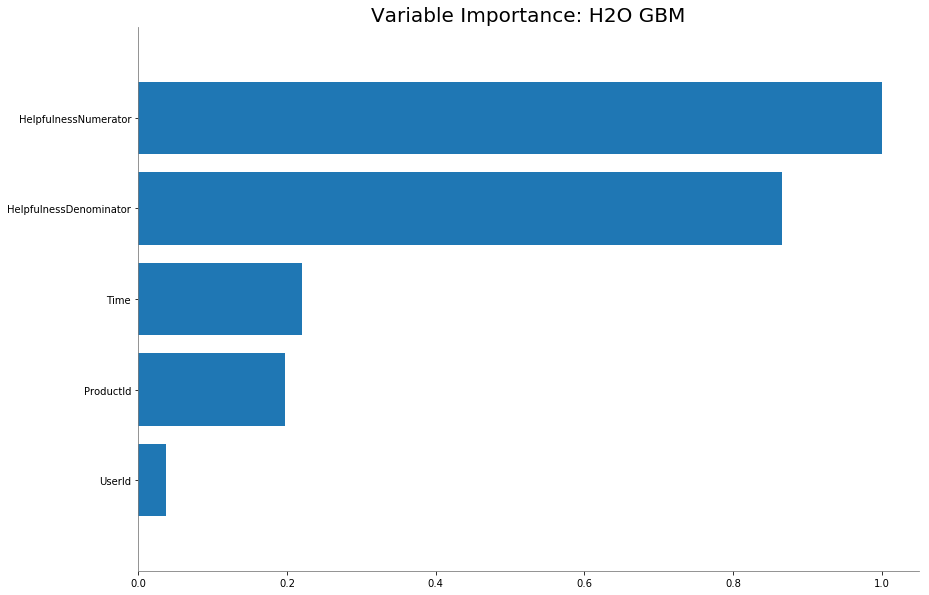

In [34]:
gbm_baseline.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


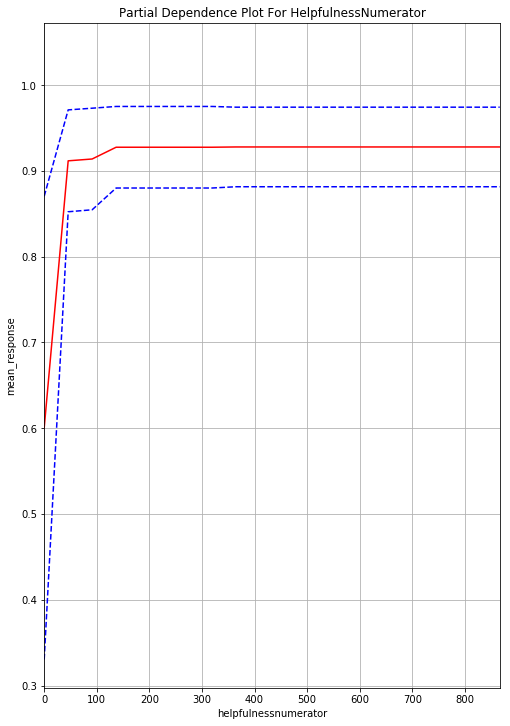

In [35]:
%matplotlib inline  
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

# Step 7 (of 10).  Train Model with Word Embeddings

We will train a GBM model with the same parameters as our baseline gbm.  This time, however, we will add the aggregated word embeddings as predictors. 

In [36]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

In [37]:
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0411651,-0.0225721,0.0977097,0.0317035,0.00827251,-0.1112,-0.0623265,0.114749,-0.109771,-0.00870417,0.0299077,0.154203,0.0150425,-0.084493,0.00862695,0.0894963,-0.0827894,0.0854073,0.0679386,-0.0246088,0.0528775,0.0235283,0.300922,-0.0627108,0.0918795,-0.0920639,-0.000319116,-0.179466,0.00880894,0.138743,-0.0251724,0.10171,-0.0276517,0.0553703,0.0142095,0.0257705,0.0537379,-0.0805859,-0.224911,0.185279,0.168018,-0.132376,-0.0218014,0.155169,-0.00640225,-0.0257301,0.0481335,0.0785774,-0.0743316,-0.109044,-0.207947,0.0932449,0.038951,-0.159145,-0.132319,0.0223576,0.0591159,-0.00286384,0.00226066,0.0196761,-0.0460211,0.0461877,-0.110922,-0.0529647,0.0705346,-0.0325621,-0.115452,0.0544586,0.0379511,0.18502,-0.0676889,0.0772619,0.152668,0.0976494,-0.00168786,-0.103011,0.0698417,0.139114,0.0996111,-0.172244,0.0735202,-0.0313859,-0.0398932,-0.00927413,0.271725,-0.113954,0.0143845,0.258758,0.0236413,0.00171477,0.0411305,-0.0261075,0.101587,-0.00111832,-0.138773,-0.103927,0.0377682,0.0439941,-0.187326,0.173025
-0.204013,0.133697,0.109404,0.359176,0.0677057,-0.153905,0.0953846,-0.0569697,0.0139357,-0.0286975,-0.133746,0.110057,0.0723812,0.0369767,-0.104913,0.143603,0.155509,0.00742212,0.159557,-0.0687317,0.126898,0.00991979,0.0431549,-0.0354102,-0.0420328,-0.0768963,0.0161643,-0.136115,0.015669,-0.0558735,0.113933,-0.0119193,-0.00352161,0.0564411,0.0816627,-0.0718474,0.0517578,-0.029018,-0.16112,0.0317373,0.100433,-0.0931166,-0.0437419,0.201529,-0.0155831,0.0583257,0.00415679,-0.001976,-0.116699,-0.0923564,-0.060528,-0.0563473,0.0965477,-0.0568415,-0.147685,0.261039,0.0865339,-0.131048,0.0482311,0.108311,-0.0184535,0.0139505,-0.0990998,-0.0822455,0.00885771,0.0834067,-0.0443234,0.0553171,-0.112787,0.0335179,0.0638032,-0.0369613,0.0304408,0.111729,0.0401858,0.0404184,0.0366817,0.31168,0.0280138,0.0251174,0.0793892,-0.0647312,-0.196166,-0.0355115,0.00958345,0.101267,0.0183896,0.0254299,-0.0537391,-0.0284413,-0.0380019,0.0513342,0.161391,-0.110431,-0.0539889,-0.0572466,0.125483,-0.0778729,-0.0200718,0.0292536
-0.125227,0.0517041,0.0694437,0.037141,-0.0636814,-0.196238,-0.00730344,0.0217337,-0.0110971,0.0888144,-0.108859,0.178154,-0.000340461,0.0784437,-0.0795309,0.11574,-0.0506225,-0.0110365,0.162512,0.0417027,0.0680936,-0.0527757,0.252225,-0.0681429,-0.00134883,-0.132345,-0.0521092,-0.180583,-0.0614254,0.0922225,-0.100433,0.0499854,0.0393939,0.110218,-0.0009505,-0.015145,0.074319,-0.0208237,-0.219759,0.0249702,0.0790242,-0.0823556,-0.0338499,0.1283,-0.0402951,0.0345159,0.04422,0.10041,0.000224503,0.0567963,-0.166523,0.00725962,0.053333,-0.0983073,-0.204821,0.151033,-0.132105,0.121548,0.00916353,-0.0344088,-0.0133541,-0.0244128,-0.0368411,-0.0448399,0.0156814,0.0172176,-0.0652199,0.0510261,-0.082076,0.226917,-0.109371,0.0212326,-0.084781,0.107864,0.196641,0.12114,-0.0846563,0.222306,0.053504,0.0201316,0.0547259,-0.0207217,-0.102015,0.028232,0.0267912,-0.0804393,0.114822,0.191742,-0.0574491,0.0109353,-0.0205228,-0.137502,0.0523642,-0.0535035,-0.0371743,-0.0511137,-0.0406468,-0.0194726,-0.1044,0.0723359
-0.0534868,-0.00940615,0.0552647,0.0284367,0.0273677,-0.272345,0.110624,0.0576282,0.0209958,-0.0502041,-0.0968481,0.19989,-0.0928355,0.0649953,-0.0193873,0.0860662,-0.127084,0.0205981,0.103328,-0.0605606,0.0169782,-0.109107,0.0678867,0.0408014,0.0734843,-0.0697606,-0.0121017,-0.19158,-0.0153094,-0.0628713,0.0658247,0.0202968,0.0806996,0.169907,0.0816592,-0.0438126,0.0312366,-0.0472819,-0.110369,0.15206,0.205178,-0.100143,-0.0755797,0.223365,-0.0154941,-0.0282394,-0.0343424,0.0121457,-0.0380958,-0.0208188,-0.0755802,-0.031608,-0.0559012,-0.0745017,-0.10482

In [38]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [39]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [40]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))

Baseline AUC: 0.616
With Embeddings AUC: 0.878


In [42]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6268657989498512: 


,0,1,Error,Rate
0,2478.0,2182.0,0.4682,(2182.0/4660.0)
1,874.0,14474.0,0.0569,(874.0/15348.0)
Total,3352.0,16656.0,0.1527,(3056.0/20008.0)


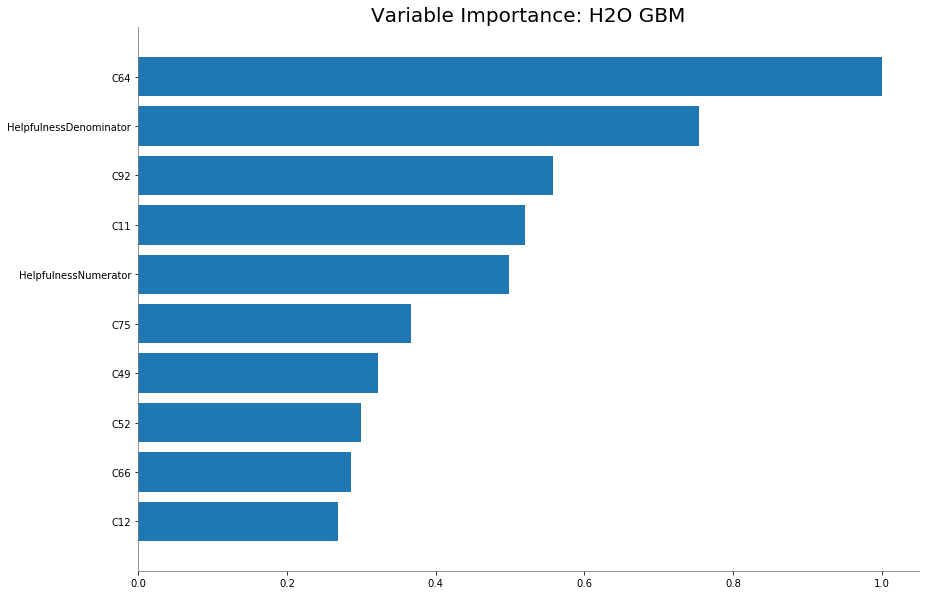

In [43]:
gbm_embeddings.varimp_plot()

# Step 8 (of 10).  Run AutoML

We will use H2O's AutoML to see if we can improve the performance further by exploring the algorithm and parameter space. 

In [44]:
from h2o.automl import H2OAutoML

automl = H2OAutoML(project_name = "positive_reviews", max_runtime_secs = 180, 
                   keep_cross_validation_models = False, keep_cross_validation_predictions = False,
                   nfolds = 3, exclude_algos = ["DRF"], seed = 1234)
automl.train(x = predictors, y = response, training_frame = ext_train, leaderboard_frame = ext_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [45]:
automl.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_0_AutoML_20180723_141420,0.90239,0.336235,0.226252,0.321566,0.103405
StackedEnsemble_BestOfFamily_0_AutoML_20180723_141420,0.902143,0.33667,0.230617,0.321703,0.103493
GLM_grid_0_AutoML_20180723_141420_model_0,0.897439,0.328441,0.231677,0.31961,0.102151
GBM_grid_0_AutoML_20180723_141420_model_0,0.896833,0.332638,0.253024,0.322285,0.103867
GBM_grid_0_AutoML_20180723_141420_model_1,0.891641,0.339505,0.260653,0.326165,0.106383


# Step 9 (of 10). Watch AutoML progress (in the H2O Flow Web UI)¶

* Go to port 54321
* In H2O Flow, go to Admin -> Jobs
* Click on the "Auto Model" job with the "positive_reviews" job name and explore it

# Step 10 (of 10).  Shutdown the H2O Cluster

In [46]:
h2o.cluster().shutdown()

H2O session _sid_9374 closed.


# Bonus: Github location for this tutorial

* https://github.com/h2oai/h2o-tutorials/tree/master/training/h2o_3_hands_on/nlp